<a href="https://colab.research.google.com/github/YeomSuWoong/SOCAR-AI-BOOT-CAMP/blob/main/Assignment_3_SEMENTIC_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

In [ ]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
print(root)
print(os.path.exists(f'{root}/diabetes.csv'))

/content/drive/MyDrive/Colab Notebooks/data
True


In [ ]:
class SOCAR_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)[:,:,0]      # 3차원으로 구성된 mask 를 label 로 쓰기 위해 변환

        mask[mask > 0] = 1

        # there is only one class
        mask = torch.as_tensor(mask, dtype=torch.uint8)

        target = {}
        target["masks"] = mask

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, target):
        image = transforms.Resize(self.size)(image)
        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
def get_transform(train):
    transforms = [ToTensor(), Resize((300,300)), Normalize()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [ ]:
seg_model = models.segmentation.deeplabv3_resnet50(pretrained=True)
seg_model

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
seg_model.classifier[4] = nn.Conv2d(256, 2, kernel_size = (1, 1), stride = (1, 1))
seg_model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
dent_train = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/train'), get_transform(train=True))
dent_valid = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/valid'), get_transform(train=False))
dent_test = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/test'), get_transform(train=False))


train_loader = DataLoader(dent_train, batch_size=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(dent_valid, batch_size=2, shuffle=False, drop_last=True)
test_loader = DataLoader(dent_test, batch_size=2, shuffle=False, drop_last=True)

In [ ]:
## Trainer class 정의

class Semantic_Seg_Trainer(nn.Module):
    def __init__(self, model,opt="adam", num_class=2, lr=0.001, has_scheduler=False, device="cpu", log_dir="logs", max_epoch=10):
        """
          Args:
            model: 사용할 model
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
        """
        super().__init__()
        weights = torch.FloatTensor([1/5, 4/5])
        self.max_epoch = max_epoch
        self.model = model                            
        self.loss = nn.CrossEntropyLoss(weight = weights)             # loss function 정의
        self.num_class = num_class

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device
        
        self.log_dir = log_dir
        if not os.path.exists(f'{root}/{self.log_dir}'): os.makedirs(f'{root}/{self.log_dir}')

    def _get_optimizer(self, opt, lr=0.001):
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=1, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": [], "train_miou": [], "valid_miou": []}
        
        checkpoint = 1
        for e in range(max_epochs):
            print(f"Start Train Epoch {e}")
            train_loss, train_miou = self._train_epoch(train_loader)
            print(f"Start Valid Epoch {e}")
            valid_loss, valid_miou = self._valid_epoch(valid_loader)
            
            
            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #
            
            history["train_miou"].append(train_miou)      # 
            history["valid_miou"].append(valid_miou)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()

            if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, train miou: {train_miou:>6f}, valid miou: {valid_miou:>6f}, time: {time.time()-start_time:>3f}")
                
                start_time = time.time()   

            self.plot_history(history, save_name=f"{root}/{self.log_dir}/log_epoch_{e}.png")       # 그래프 출력
            #################################################################################################
            #                                                                                               #
            # TODO : 한 epoch 의 학습이 끝날때 마다 model 을 save 하는 코드를 작성해봅시다.                             #
            #        graph 저장 코드를 참고하여 저장되는 model 의 이름에 몇 epoch 인지 나타나게 해봅시다.                  # 
            #                                                                                               #
            #################################################################################################
            torch.save({
                'model': f"Deeplabv3-{e}",
                'epoch': e,
                'model_state_dict': seg_model.state_dict(),
                'desription': f'Model epoch-{checkpoint}',
            },
            f'{root}/{self.log_dir}/checkpoint-{checkpoint}.pth')
            checkpoint += 1

    def _train_epoch(self, train_loader, disp_step=10):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
        
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        for (x, y) in train_loader:        # x: data, y:label
            cnt += 1

            x = x.to(self.device)
            label = y['masks'].to(self.device).type(torch.long)
            
            out = self.model(x)              # model이 예측한 output
            loss = self.loss(out['out'], label)       

            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    
            
            out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)           # meanIoU 계산을 위한 데이터 변형
            out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)               #
            
            ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long)) # ious[0]:background IoU
            ious[1] += self.batch_segmentation_iou(out_target, label)                                         # ious[1]:파손 IoU
            
            if cnt % disp_step == 0:
                iou_back = ious[0]/(cnt*x.shape[0])
                iou_scratch = ious[1]/(cnt*x.shape[0])
                miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                
                print(f"Iter: {cnt}/{len(train_loader)}, train epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                start_time = time.time()   

        epoch_loss /= len(train_loader)  
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Train loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou
  
    def _valid_epoch(self, valid_loader, disp_step=10):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)
                      
                epoch_loss += loss.to("cpu").item()
                
                out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                    

                
                
                if cnt % disp_step == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, valid epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()   

        epoch_loss /= len(valid_loader)
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Valid loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou

    def plot_history(self, history, save_name=None):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss","valid_loss",  }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(16, 8))
        
        
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["train_loss"], color="red", label="train loss")
        ax.plot(history["valid_loss"], color="blue", label="valid loss")
        ax.title.set_text("Loss")
        ax.legend()
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["train_miou"], color="red", label="train miou")
        ax.plot(history["valid_miou"], color="blue", label="valid miou")
        ax.title.set_text("miou")
        ax.legend()

        plt.show()
                      
        if not save_name == None:     # graph 저장
            plt.savefig(save_name)
                      
        

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()
                      
                out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                
                if cnt % 10 == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, test epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()  

        epoch_loss /= len(test_loader)
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        
        print(f"Test loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

    
    def batch_segmentation_iou(self, outputs, labels):
        """
            outputs, labels : (batch, h, w)
        """
        
        SMOOTH = 1e-6

        intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
        union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

        iou = (intersection + SMOOTH) / (union + SMOOTH)
         # TODO
        
        #################################################################################################
        #                                                                                               #
        # TODO : 위 코드를 보고 IoU 를 계산하는 코드를 만들어봅시다.                                    #
        # hint : 나누기에서 0으로 나누면 error 가 발생하기 때문에 이를 피하기 위해 분자와 분모에        #
        #        아주 작은 수인 SMOOTH 를 더해줍시다                                                    #
        #        ex) x / y   --->   (x + SMOOTH) / (y + SMOOTH)                                         #
        #                                                                                               #
        #################################################################################################
        
        
        return torch.sum(iou).to("cpu").numpy()

# 새 섹션

===== Train Start =====
Start Train Epoch 0
Iter: 10/100, train epcoh loss: 0.011624, miou: 0.898294, iou_back : 0.996143, iou_scratch : 0.800445, time: 2.748799
Iter: 20/100, train epcoh loss: 0.013012, miou: 0.888505, iou_back : 0.995272, iou_scratch : 0.781738, time: 2.766579
Iter: 30/100, train epcoh loss: 0.014676, miou: 0.883041, iou_back : 0.994641, iou_scratch : 0.771441, time: 2.672173
Iter: 40/100, train epcoh loss: 0.016428, miou: 0.878715, iou_back : 0.993805, iou_scratch : 0.763625, time: 2.755768
Iter: 50/100, train epcoh loss: 0.017113, miou: 0.878441, iou_back : 0.993614, iou_scratch : 0.763268, time: 2.912046
Iter: 60/100, train epcoh loss: 0.017766, miou: 0.883671, iou_back : 0.993338, iou_scratch : 0.774003, time: 2.791805
Iter: 70/100, train epcoh loss: 0.017514, miou: 0.882558, iou_back : 0.993372, iou_scratch : 0.771744, time: 2.759471
Iter: 80/100, train epcoh loss: 0.017602, miou: 0.883777, iou_back : 0.993387, iou_scratch : 0.774167, time: 2.714564
Iter: 90/100

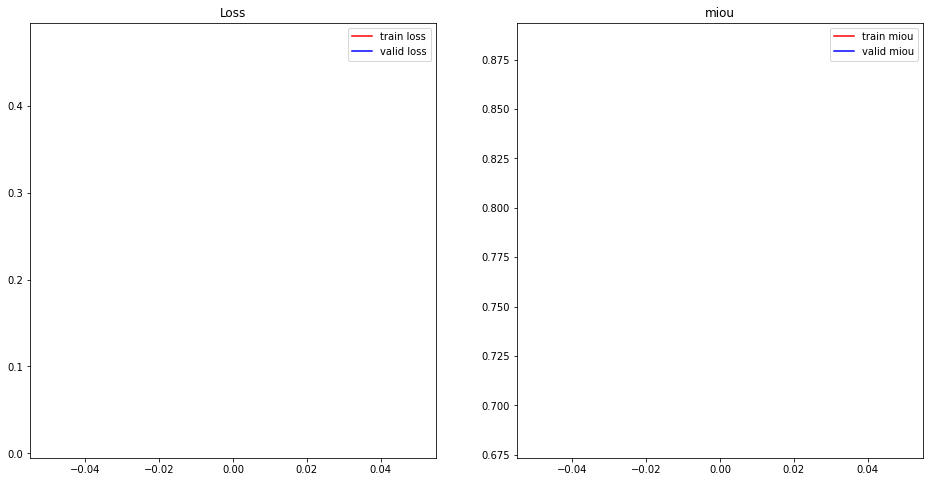

Start Train Epoch 1
Iter: 10/100, train epcoh loss: 0.013706, miou: 0.865516, iou_back : 0.995508, iou_scratch : 0.735525, time: 2.746650
Iter: 20/100, train epcoh loss: 0.015340, miou: 0.884607, iou_back : 0.994381, iou_scratch : 0.774832, time: 2.756595
Iter: 30/100, train epcoh loss: 0.017631, miou: 0.884792, iou_back : 0.993336, iou_scratch : 0.776247, time: 2.687029
Iter: 40/100, train epcoh loss: 0.017243, miou: 0.883248, iou_back : 0.993460, iou_scratch : 0.773036, time: 2.931250
Iter: 50/100, train epcoh loss: 0.017444, miou: 0.880023, iou_back : 0.993533, iou_scratch : 0.766514, time: 2.878358
Iter: 60/100, train epcoh loss: 0.017794, miou: 0.884480, iou_back : 0.993365, iou_scratch : 0.775594, time: 2.816457
Iter: 70/100, train epcoh loss: 0.017903, miou: 0.884459, iou_back : 0.993458, iou_scratch : 0.775460, time: 2.742288
Iter: 80/100, train epcoh loss: 0.018102, miou: 0.884113, iou_back : 0.993282, iou_scratch : 0.774943, time: 2.763322
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

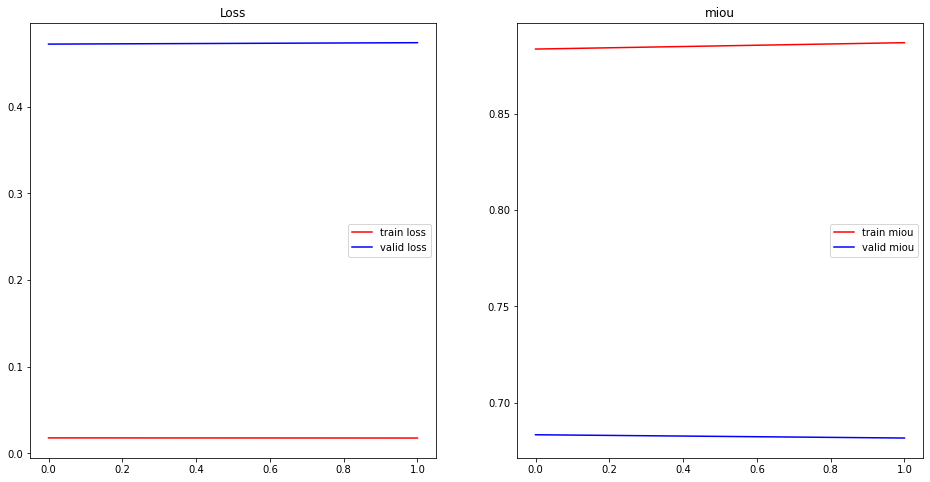

Start Train Epoch 2
Iter: 10/100, train epcoh loss: 0.022630, miou: 0.896150, iou_back : 0.990883, iou_scratch : 0.801417, time: 2.807322
Iter: 20/100, train epcoh loss: 0.020104, miou: 0.901094, iou_back : 0.992153, iou_scratch : 0.810034, time: 2.749273
Iter: 30/100, train epcoh loss: 0.018948, miou: 0.898866, iou_back : 0.992644, iou_scratch : 0.805088, time: 2.732068
Iter: 40/100, train epcoh loss: 0.018842, miou: 0.892392, iou_back : 0.992529, iou_scratch : 0.792255, time: 2.830730
Iter: 50/100, train epcoh loss: 0.018233, miou: 0.887279, iou_back : 0.993034, iou_scratch : 0.781523, time: 2.856873
Iter: 60/100, train epcoh loss: 0.017161, miou: 0.885058, iou_back : 0.993510, iou_scratch : 0.776607, time: 2.782382
Iter: 70/100, train epcoh loss: 0.017308, miou: 0.881294, iou_back : 0.993525, iou_scratch : 0.769063, time: 2.765802
Iter: 80/100, train epcoh loss: 0.017346, miou: 0.884352, iou_back : 0.993481, iou_scratch : 0.775223, time: 2.737516
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

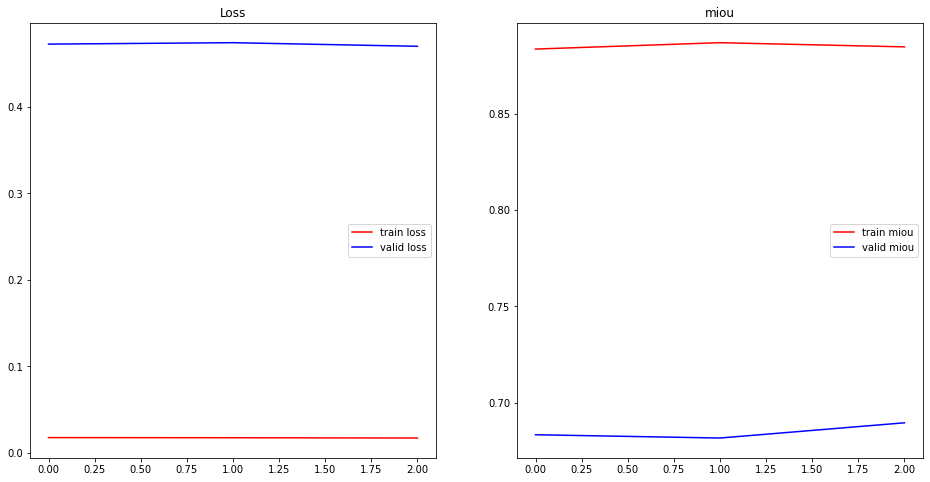

Start Train Epoch 3
Iter: 10/100, train epcoh loss: 0.015507, miou: 0.866165, iou_back : 0.994753, iou_scratch : 0.737577, time: 2.737332
Iter: 20/100, train epcoh loss: 0.016630, miou: 0.871028, iou_back : 0.994622, iou_scratch : 0.747434, time: 2.768933
Iter: 30/100, train epcoh loss: 0.018218, miou: 0.877591, iou_back : 0.993638, iou_scratch : 0.761544, time: 2.803484
Iter: 40/100, train epcoh loss: 0.017490, miou: 0.883405, iou_back : 0.993902, iou_scratch : 0.772908, time: 2.887569
Iter: 50/100, train epcoh loss: 0.017371, miou: 0.885576, iou_back : 0.993806, iou_scratch : 0.777346, time: 2.905805
Iter: 60/100, train epcoh loss: 0.017358, miou: 0.886785, iou_back : 0.993710, iou_scratch : 0.779859, time: 2.856863
Iter: 70/100, train epcoh loss: 0.017064, miou: 0.891175, iou_back : 0.993717, iou_scratch : 0.788633, time: 2.736945
Iter: 80/100, train epcoh loss: 0.017099, miou: 0.890188, iou_back : 0.993610, iou_scratch : 0.786766, time: 2.729049
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

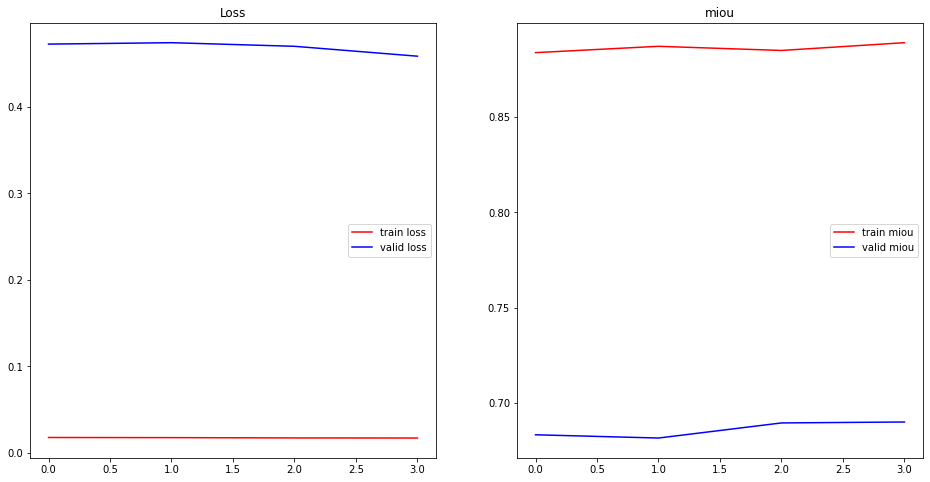

Start Train Epoch 4
Iter: 10/100, train epcoh loss: 0.014380, miou: 0.895235, iou_back : 0.994534, iou_scratch : 0.795935, time: 2.763213
Iter: 20/100, train epcoh loss: 0.015038, miou: 0.891543, iou_back : 0.994596, iou_scratch : 0.788490, time: 2.815203
Iter: 30/100, train epcoh loss: 0.017550, miou: 0.886965, iou_back : 0.993393, iou_scratch : 0.780538, time: 2.746129
Iter: 40/100, train epcoh loss: 0.019054, miou: 0.890877, iou_back : 0.992704, iou_scratch : 0.789051, time: 3.310687
Iter: 50/100, train epcoh loss: 0.018809, miou: 0.888928, iou_back : 0.992892, iou_scratch : 0.784965, time: 3.327185
Iter: 60/100, train epcoh loss: 0.018801, miou: 0.893195, iou_back : 0.992776, iou_scratch : 0.793614, time: 2.769115
Iter: 70/100, train epcoh loss: 0.018232, miou: 0.892233, iou_back : 0.993028, iou_scratch : 0.791438, time: 2.712436
Iter: 80/100, train epcoh loss: 0.017589, miou: 0.889414, iou_back : 0.993338, iou_scratch : 0.785489, time: 2.725250
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

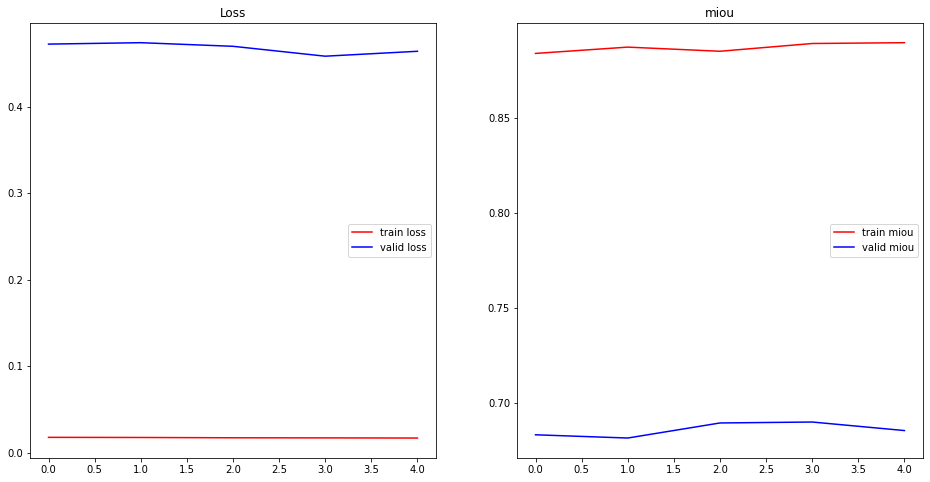

Start Train Epoch 5
Iter: 10/100, train epcoh loss: 0.018006, miou: 0.899701, iou_back : 0.992873, iou_scratch : 0.806529, time: 2.810185
Iter: 20/100, train epcoh loss: 0.019341, miou: 0.886571, iou_back : 0.992321, iou_scratch : 0.780821, time: 2.738747
Iter: 30/100, train epcoh loss: 0.019597, miou: 0.892432, iou_back : 0.992213, iou_scratch : 0.792650, time: 2.779270
Iter: 40/100, train epcoh loss: 0.019969, miou: 0.889321, iou_back : 0.992132, iou_scratch : 0.786511, time: 3.025176
Iter: 50/100, train epcoh loss: 0.018968, miou: 0.887579, iou_back : 0.992606, iou_scratch : 0.782551, time: 2.781668
Iter: 60/100, train epcoh loss: 0.018511, miou: 0.883653, iou_back : 0.992818, iou_scratch : 0.774488, time: 2.718730
Iter: 70/100, train epcoh loss: 0.018188, miou: 0.884424, iou_back : 0.993106, iou_scratch : 0.775742, time: 2.732192
Iter: 80/100, train epcoh loss: 0.017586, miou: 0.885634, iou_back : 0.993373, iou_scratch : 0.777895, time: 2.759876
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

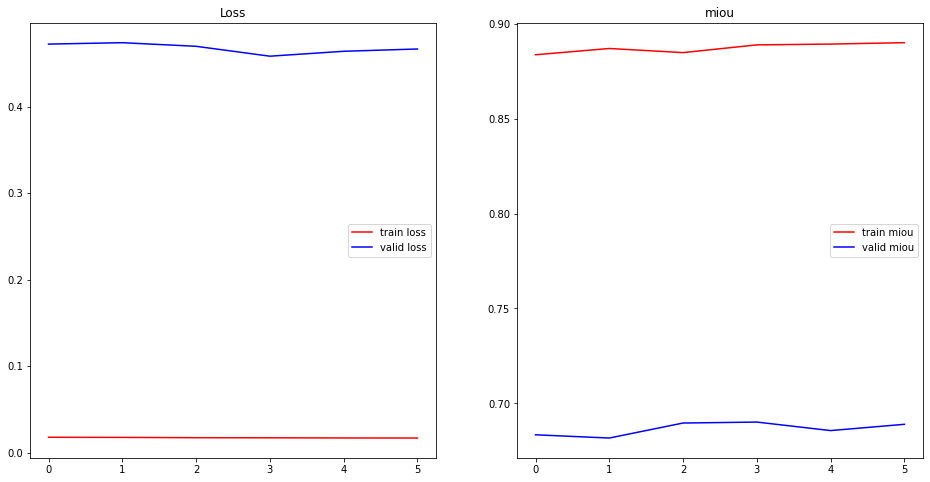

Start Train Epoch 6
Iter: 10/100, train epcoh loss: 0.013704, miou: 0.876563, iou_back : 0.995143, iou_scratch : 0.757984, time: 2.748109
Iter: 20/100, train epcoh loss: 0.014454, miou: 0.885812, iou_back : 0.994725, iou_scratch : 0.776900, time: 2.742945
Iter: 30/100, train epcoh loss: 0.015787, miou: 0.892848, iou_back : 0.994438, iou_scratch : 0.791257, time: 2.822294
Iter: 40/100, train epcoh loss: 0.016397, miou: 0.893571, iou_back : 0.994136, iou_scratch : 0.793006, time: 2.941915
Iter: 50/100, train epcoh loss: 0.016131, miou: 0.899080, iou_back : 0.994169, iou_scratch : 0.803991, time: 2.823736
Iter: 60/100, train epcoh loss: 0.015893, miou: 0.897523, iou_back : 0.994192, iou_scratch : 0.800854, time: 2.710490
Iter: 70/100, train epcoh loss: 0.017017, miou: 0.896205, iou_back : 0.993584, iou_scratch : 0.798825, time: 2.763941
Iter: 80/100, train epcoh loss: 0.016728, miou: 0.892453, iou_back : 0.993759, iou_scratch : 0.791148, time: 2.734291
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

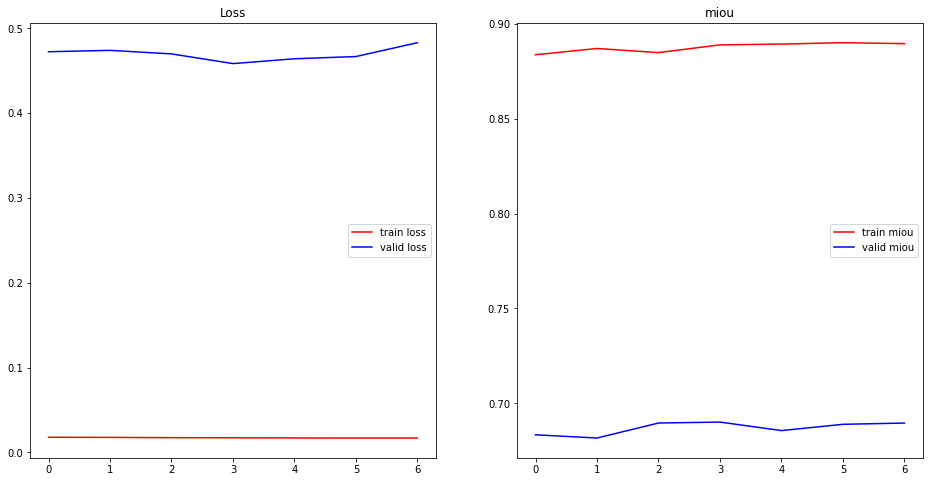

Start Train Epoch 7
Iter: 10/100, train epcoh loss: 0.018464, miou: 0.902069, iou_back : 0.993520, iou_scratch : 0.810618, time: 2.776738
Iter: 20/100, train epcoh loss: 0.017569, miou: 0.889483, iou_back : 0.993498, iou_scratch : 0.785468, time: 2.740027
Iter: 30/100, train epcoh loss: 0.016670, miou: 0.894551, iou_back : 0.993821, iou_scratch : 0.795281, time: 2.688300
Iter: 40/100, train epcoh loss: 0.015841, miou: 0.895631, iou_back : 0.994112, iou_scratch : 0.797151, time: 2.903317
Iter: 50/100, train epcoh loss: 0.015529, miou: 0.888193, iou_back : 0.994348, iou_scratch : 0.782039, time: 2.804892
Iter: 60/100, train epcoh loss: 0.016353, miou: 0.885150, iou_back : 0.993919, iou_scratch : 0.776381, time: 2.759670
Iter: 70/100, train epcoh loss: 0.016175, miou: 0.889467, iou_back : 0.994021, iou_scratch : 0.784913, time: 2.800831
Iter: 80/100, train epcoh loss: 0.016600, miou: 0.890541, iou_back : 0.993922, iou_scratch : 0.787161, time: 2.742600
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

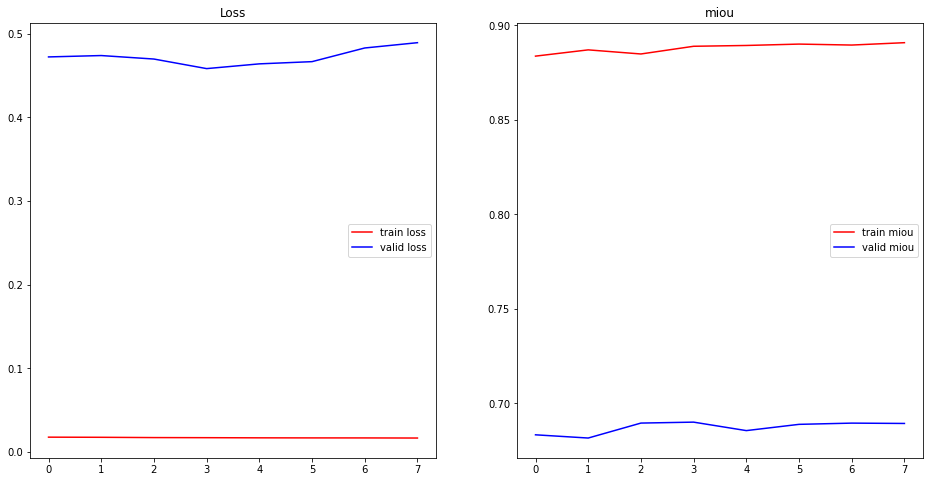

Start Train Epoch 8
Iter: 10/100, train epcoh loss: 0.013676, miou: 0.878210, iou_back : 0.995323, iou_scratch : 0.761098, time: 2.771028
Iter: 20/100, train epcoh loss: 0.016941, miou: 0.876623, iou_back : 0.993774, iou_scratch : 0.759473, time: 2.776915
Iter: 30/100, train epcoh loss: 0.017780, miou: 0.888042, iou_back : 0.993468, iou_scratch : 0.782616, time: 2.774261
Iter: 40/100, train epcoh loss: 0.017475, miou: 0.893181, iou_back : 0.993786, iou_scratch : 0.792576, time: 2.935415
Iter: 50/100, train epcoh loss: 0.016524, miou: 0.893531, iou_back : 0.994030, iou_scratch : 0.793032, time: 2.883524
Iter: 60/100, train epcoh loss: 0.016899, miou: 0.885273, iou_back : 0.993762, iou_scratch : 0.776784, time: 2.752100
Iter: 70/100, train epcoh loss: 0.017067, miou: 0.883833, iou_back : 0.993651, iou_scratch : 0.774016, time: 2.819359
Iter: 80/100, train epcoh loss: 0.016832, miou: 0.885932, iou_back : 0.993739, iou_scratch : 0.778125, time: 2.743408
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

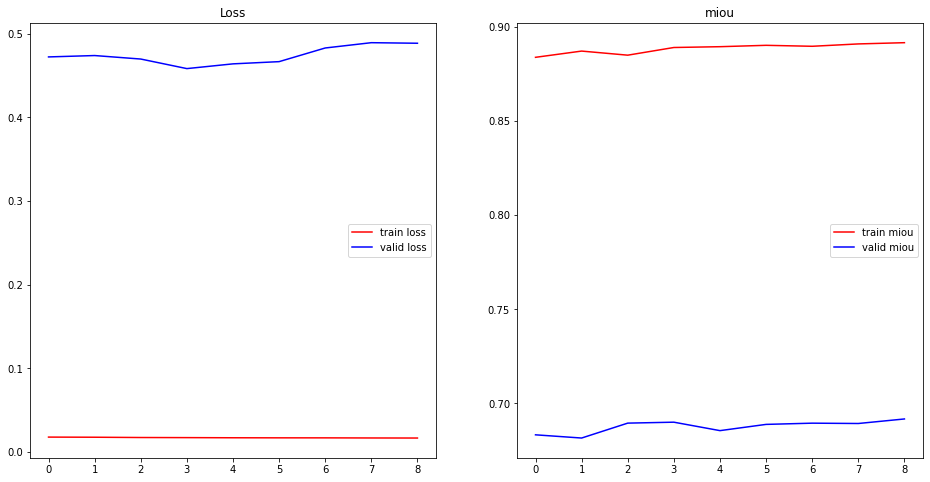

Start Train Epoch 9
Iter: 10/100, train epcoh loss: 0.014600, miou: 0.903922, iou_back : 0.994549, iou_scratch : 0.813295, time: 2.767424
Iter: 20/100, train epcoh loss: 0.015327, miou: 0.902668, iou_back : 0.994266, iou_scratch : 0.811071, time: 2.867991
Iter: 30/100, train epcoh loss: 0.016184, miou: 0.896010, iou_back : 0.994014, iou_scratch : 0.798006, time: 2.779943
Iter: 40/100, train epcoh loss: 0.016642, miou: 0.893927, iou_back : 0.993782, iou_scratch : 0.794072, time: 2.986540
Iter: 50/100, train epcoh loss: 0.017331, miou: 0.892874, iou_back : 0.993456, iou_scratch : 0.792293, time: 2.939770
Iter: 60/100, train epcoh loss: 0.018137, miou: 0.892382, iou_back : 0.993202, iou_scratch : 0.791562, time: 2.841697
Iter: 70/100, train epcoh loss: 0.017809, miou: 0.892511, iou_back : 0.993362, iou_scratch : 0.791661, time: 2.809532
Iter: 80/100, train epcoh loss: 0.017232, miou: 0.892402, iou_back : 0.993571, iou_scratch : 0.791233, time: 2.744537
Iter: 90/100, train epcoh loss: 0.01

<Figure size 432x288 with 0 Axes>

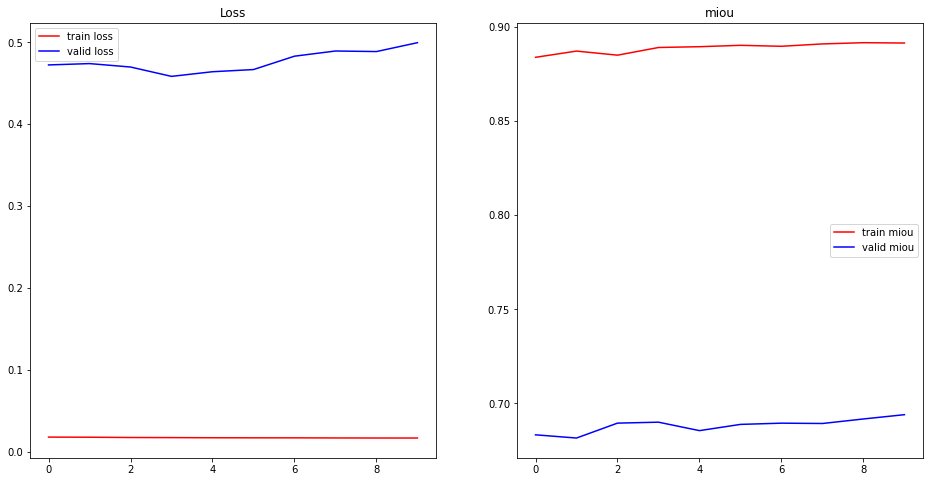

Training time : 523.916588


<Figure size 432x288 with 0 Axes>

In [ ]:
device = "cuda"
trainer = Semantic_Seg_Trainer(model=seg_model, opt="adam", lr=0.00001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

In [ ]:
checkpoint = torch.load(f'{root}/logs/checkpoint-10.pth')
seg_model.load_state_dict(checkpoint["model_state_dict"])

checkpoint_epoch = checkpoint["epoch"]
checkpoint_description = checkpoint["desription"]
checkpoint_model_state_dict = checkpoint['model_state_dict']

print(checkpoint_description)
print(checkpoint_model_state_dict)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

        ...,


        [[[ 0.0124]],

         [[-0.0268]],

         [[-0.0027]],

         ...,

         [[-0.0060]],

         [[ 0.0038]],

         [[-0.0130]]],


        [[[ 0.0158]],

         [[-0.0180]],

         [[ 0.0106]],

         ...,

         [[-0.0045]],

         [[ 0.0106]],

         [[-0.0244]]],


        [[[-0.0185]],

         [[-0.0159]],

         [[ 0.0174]],

         ...,

         [[ 0.0064]],

         [[-0.0159]],

         [[ 0.0128]]]], device='cuda:0')), ('backbone.layer4.1.bn1.weight', tensor([0.1228, 0.1083, 0.1145, 0.1457, 0.1256, 0.1241, 0.1867, 0.1034, 0.0887,
        0.1184, 0.1088, 0.1299, 0.1284, 0.0956, 0.1165, 0.1364, 0.1069, 0.1335,
        0.1050, 0.1340, 0.1057, 0.1195, 0.1053, 0.1423, 0.1159, 0.1141, 0.0793,
        0.1023, 0.1461, 0.1044, 0.0965, 0.1317, 0.1477, 0.0953, 0.1071, 0.0753,
        0.1105, 0.1146, 0.1005, 0.1301, 0.1059, 0.0983, 0.1362, 0.1194, 0.0779,
        0.1233, 0.1374, 0.0969, 

In [ ]:
image = Image.open(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/test/images/20190526_9560_23986636_fedb1aa67ec7c51df42d63c0b59590fa.jpg'))
mask = Image.open(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/test/masks/20190526_9560_23986636_fedb1aa67ec7c51df42d63c0b59590fa.jpg'))


infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image).to(device)

output = seg_model(input_image.unsqueeze(dim=0))
output['out'].shape

torch.Size([1, 2, 800, 600])

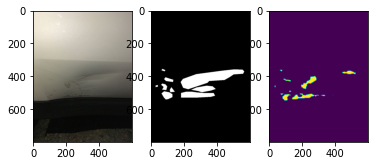

In [ ]:
image1 = Image.open(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/test/images/20190526_9560_23986636_fedb1aa67ec7c51df42d63c0b59590fa.jpg'))
image2 = Image.open(os.path.join(root,'accida_segmentation_dataset_v1/scratch_small/test/masks/20190526_9560_23986636_fedb1aa67ec7c51df42d63c0b59590fa.jpg'))
cls = torch.argmax(output['out'][0].to("cpu"), dim=0).numpy()
out = np.zeros_like(cls)
out[cls==1] = 1

plt.subplot(1,3,1)
plt.imshow(image1)

plt.subplot(1,3,2)
plt.imshow(image2)

plt.subplot(1,3,3)
plt.imshow(out)